Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


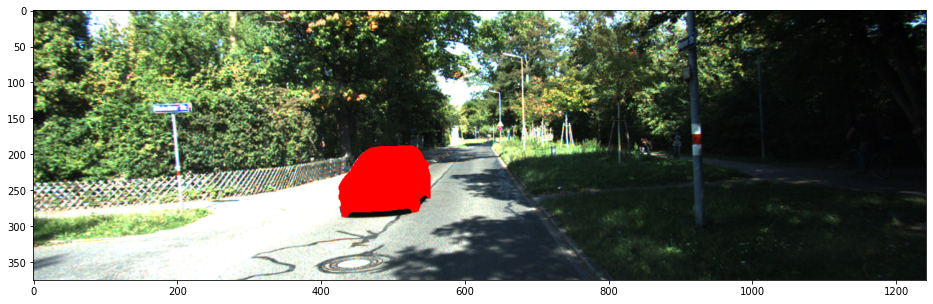

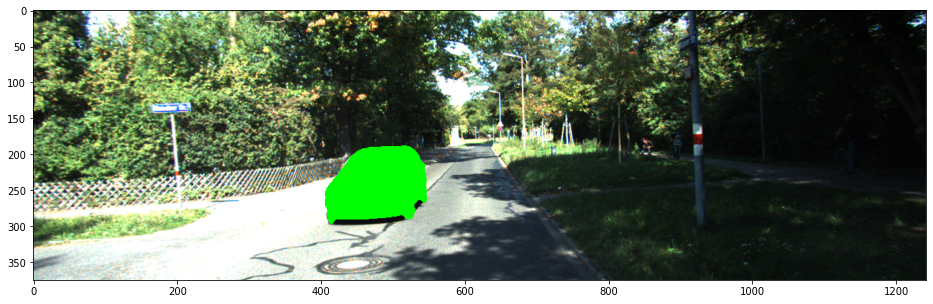

In [1]:
import os
import torch
import numpy as np
import open3d as o3d
import torch.nn as nn
import skimage.io as sio
import torchvision as tv
import matplotlib.pyplot as plt
from skimage.transform import resize

K = np.array([7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01, 
              0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01, 
              0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]).reshape(3, 4)[:3, :3]

b = 0.54
fx = K[0, 0]

seq = "0007"
num = 0

gt_img0 = sio.imread("./sample_data/000000_gt.png")
# plt.figure(figsize=(16, 16))
# plt.imshow(gt_img0)

gt_img1 = sio.imread("./sample_data/000001_gt.png")
# plt.figure(figsize=(16, 16))
# plt.imshow(gt_img1)

img0 = sio.imread("./sample_data/000000_img.png")
s0 = (gt_img0[:, :, -1] == 1).nonzero()
img0[s0[0], s0[1]] = torch.tensor([255, 0, 0])
plt.figure(figsize=(16, 16))
plt.imshow(img0)

img1 = sio.imread("./sample_data/000001_img.png")
s1 = (gt_img1[:, :, -1] == 1).nonzero()
img1[s1[0], s1[1]] = (0, 255, 0)
plt.figure(figsize=(16, 16))
plt.imshow(img1)

disp0 = np.load("./sample_data/000000_disp.npy")
disp1 = np.load("./sample_data/000001_disp.npy")

depth0 = (b*fx)/disp0
depth1 = (b*fx)/disp1

K_inv = np.linalg.inv(K)

In [2]:
def homogenize(pts):
    m, n = pts.shape
    return np.concatenate([pts, np.ones((1, n))], axis=0)

def dehomogenize(pts):
    return (pts/pts[-1])[:-1]

idxs0 = np.stack(s0, axis=0)
idxs1 = np.stack(s1, axis=0)

s0_depth = depth0[s0[0], s0[1]]
s1_depth = depth1[s1[0], s1[1]]

norm_coords0 = K_inv.dot(homogenize(idxs0))
norm_coords1 = K_inv.dot(homogenize(idxs1))

pts0 = norm_coords0 * s0_depth
pts1 = norm_coords1 * s1_depth

In [3]:
colors0 = img0[s0[0], s0[1]]
colors1 = img1[s1[0], s1[1]]

pcd0 = o3d.geometry.PointCloud()
pcd0.points = o3d.utility.Vector3dVector(pts0.T)
pcd0.colors = o3d.utility.Vector3dVector(colors0)

pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(pts1.T)
pcd1.colors = o3d.utility.Vector3dVector(colors1)

o3d.visualization.draw_geometries([pcd0, pcd1])

In [4]:
img_02_path = '/external/datasets/kitti/tracking/kitti-step/training/image_02/0007'
mask_path = '/external/datasets/kitti/tracking/kitti-step/panoptic_maps/trimmed/val/0007'
img_03_path = '/external/datasets/kitti/tracking/kitti-step/training/image_03/0007'

img_02_files = list(sorted([os.path.join(img_02_path, x) for x in os.listdir(img_02_path)]))
img_03_files = list(sorted([os.path.join(img_03_path, x) for x in os.listdir(img_03_path)]))
mask_files = list(sorted([os.path.join(mask_path, x) for x in os.listdir(mask_path)]))

assert(len(img_02_files) == len(img_03_files) == len(mask_files))

files = list(zip(img_02_files, img_03_files, mask_files))

skipped = 0
valid_mask_pairs = []
with open('../../GwcNet/filenames/tmp.txt', 'w') as f:
    for i in range(len(files)-1):
        img_02_path, img_03_path, mask_path = files[i]
        mask0 = sio.imread(mask_path)
        mask1 = sio.imread(mask_files[i+1])
        car_mask0 = (mask0[:, :, 0] == 13)
        car_mask1 = (mask1[:, :, 0] == 13)

        if car_mask0.sum() == 0 or car_mask1.sum() == 0:
            skipped += 1
            continue
        valid_mask_pairs.append((mask_path, mask_files[i+1]))
        f.write(f"{img_02_path} {img_03_path}\n")
print(f"Skipped {skipped} frames")

Skipped 87 frames


In [9]:
from tqdm.notebook import trange, tqdm

disp_path = "/external/datasets/two_frame_car/disparity/train/0007"
save_path = "/external/datasets/two_frame_car/pcds/train/0007"
os.makedirs(save_path, exist_ok=True)

disp_files = list(sorted([os.path.join(disp_path, x) for x in os.listdir(disp_path)]))

for pair in tqdm(valid_mask_pairs):
    mask0_path, mask1_path = pair
    disp0_path, disp1_path = disp_files[0], disp_files[1]
    mask0 = sio.imread(mask0_path)
    mask1 = sio.imread(mask1_path)
    
    class_id = 13
    
    mask0_ids = set(mask0[mask0[:, :, 0] == 13][:, -1].flatten())
    mask1_ids = set(mask1[mask1[:, :, 0] == 13][:, -1].flatten())
    matched_ids = mask0_ids.intersection(mask1_ids)
    
    if not matched_ids:
        continue
    
    for id_ in matched_ids:
        mask0_idxs = ((mask0[:, :, 0] == 13) * (mask0[:, :, -1] == id_)).nonzero()
        mask1_idxs = ((mask1[:, :, 0] == 13) * (mask1[:, :, -1] == id_)).nonzero()

        disp0 = np.load(disp0_path)
        disp1 = np.load(disp1_path)
        depth0 = (b*fx)/disp0
        depth1 = (b*fx)/disp1

        s0 = np.stack(mask0_idxs, axis=0)
        s1 = np.stack(mask1_idxs, axis=0)

        s0_depth = depth0[s0[0], s0[1]]
        s1_depth = depth1[s1[0], s1[1]]

        norm_coords0 = K_inv.dot(homogenize(s0))
        norm_coords1 = K_inv.dot(homogenize(s1))

        pts0 = norm_coords0 * s0_depth
        pts1 = norm_coords1 * s1_depth
        
        basename0 = mask0_path.split('/')[-1].split('.')[0]
        basename1 = mask1_path.split('/')[-1].split('.')[0]
        
        os.makedirs(os.path.join(save_path, f"{basename0}_{class_id}_{id_}"), exist_ok=True)
        
        pc0_path = os.path.join(save_path, f"{basename0}_{class_id}_{id_}", "pc1.npy")
        pc1_path = os.path.join(save_path, f"{basename0}_{class_id}_{id_}", "pc2.npy")
        
        np.save(pc0_path, pts0)
        np.save(pc1_path, pts1)

  0%|          | 0/712 [00:00<?, ?it/s]

In [26]:
import shutil
save_path = "/external/datasets/two_frame_car/pcds/train/0007"

train_folders = os.listdir(save_path)[:-400]
val_folders = os.listdir(save_path)[-400:]

for train_path in [os.path.join(save_path, x) for x in val_folders]:
    split_path = train_path.split('train')
    new_path = split_path[0]+ "val"+split_path[1]
    shutil.move(train_path, new_path)